# POB Lab 14 Face detection and verification

In [ ]:
# Constants:
FILE_NAME = 'photo.jpg'

### Imports

In [ ]:
from google.colab.patches import cv2_imshow
import cv2
import numpy as np
from matplotlib import pyplot as plt




In [ ]:
from IPython.display import display, Javascript, Image
from base64 import b64decode, b64encode
import ipywidgets as widgets

import cv2
import numpy as np
from numpy import asarray

from matplotlib import pyplot as plt
from matplotlib import pyplot
from matplotlib.patches import Rectangle
from matplotlib.patches import Circle

import PIL
from PIL import Image as Img
import PIL.Image
import io
import html
import time
import os

from mtcnn.mtcnn import MTCNN
from scipy.spatial.distance import cosine

from keras import applications
from keras_vggface.vggface import VGGFace
from keras_vggface.utils import preprocess_input

from deepface import DeepFace

from ipywebrtc import CameraStream, ImageRecorder

### Helper functions

In [ ]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

# Face detection


## Haar Cascade Classifier
For this tutorial we will run a simple object detection algorithm called Haar Cascade on our images and video fetched from our webcam. OpenCV has a pre-trained Haar Cascade face detection model. 

https://docs.opencv.org/3.4/db/d28/tutorial_cascade_classifier.html


In [ ]:
# initialize the Haar Cascade face detection model
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
eyes_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye_tree_eyeglasses.xml') # haarcascade_eye_tree_eyeglasses  haarcascade_eye
profile_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_profileface.xml')


<IPython.core.display.Javascript object>

(480, 640)
Saved to photo.jpg


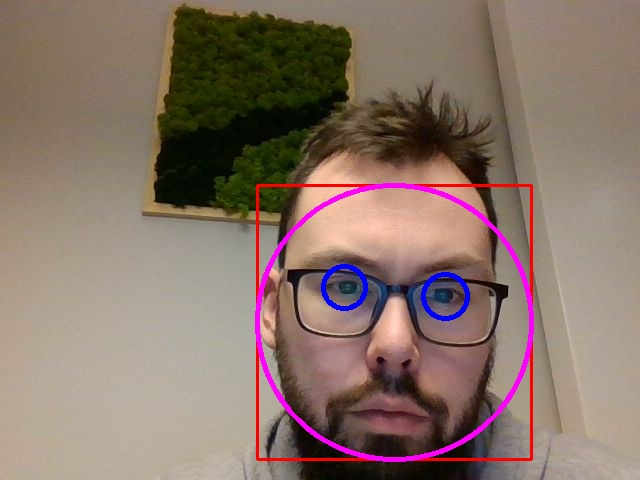

In [ ]:
try:
  filename = take_photo_faceDetect(FILE_NAME)
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

<IPython.core.display.Javascript object>

Saved to photo.jpg
(480, 640)


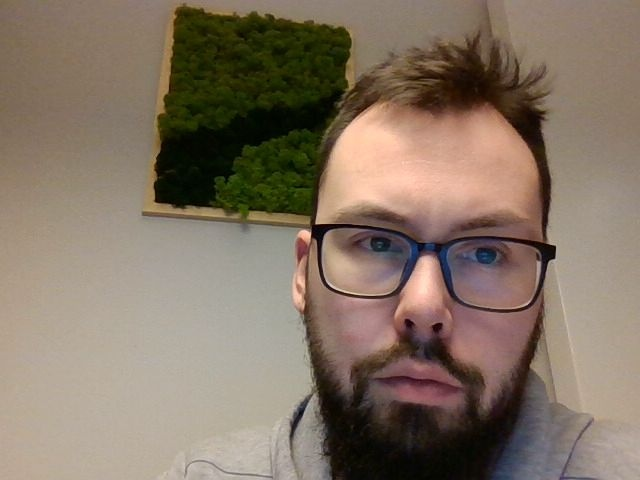

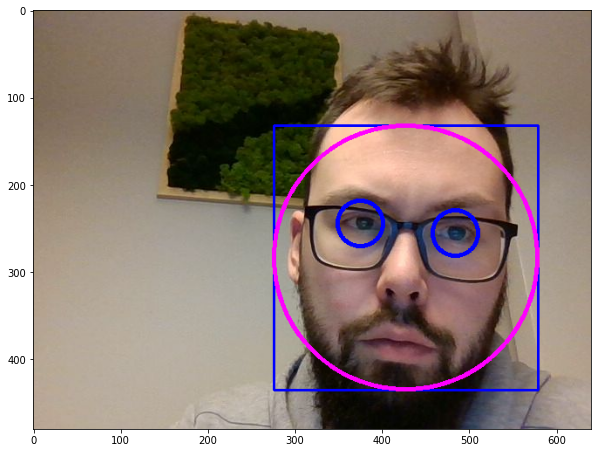

In [ ]:
try:
  filename, img = take_photo(FILE_NAME)
  print('Saved to {}'.format(filename))
  
  # grayscale img
  gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  print(gray.shape)

  # get face bounding box coordinates using Haar Cascade
  faces = face_cascade.detectMultiScale(gray)
  
  # draw face bounding box on image
  for (x,y,w,h) in faces:
      img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)

      center = (x + w//2, y + h//2)
      img = cv2.ellipse(img, center, (w//2, h//2), 0, 0, 360, (255, 0, 255), 4)
      faceROI = gray[y:y+h,x:x+w]
      #-- In each face, detect eyes
      eyes = eyes_cascade.detectMultiScale(faceROI)
      for (x2,y2,w2,h2) in eyes:
          eye_center = (x + x2 + w2//2, y + y2 + h2//2)
          radius = int(round((w2 + h2)*0.25))
          img = cv2.circle(img, eye_center, radius, (255, 0, 0 ), 4)

  # Show the image which was just taken.
  display(Image(filename))
  #frame = cv2.hconcat((img_clear, img))
  #cv2_imshow(frame)
  plt.figure(figsize=(10,10))
  im_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  plt.imshow(im_rgb)
  fname,fext = os.path.splitext(os.path.basename(filename))

  cv2.imwrite(fname+'_face'+fext, img)
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

  

### Webcam Live Stream
Running code on webcam video is a little more complex than images. We need to start a video stream using our webcam as input. Then we run each frame through our progam (face detection) and create an overlay image that contains bounding box of detection(s). We then overlay the bounding box image back onto the next frame of our video stream.

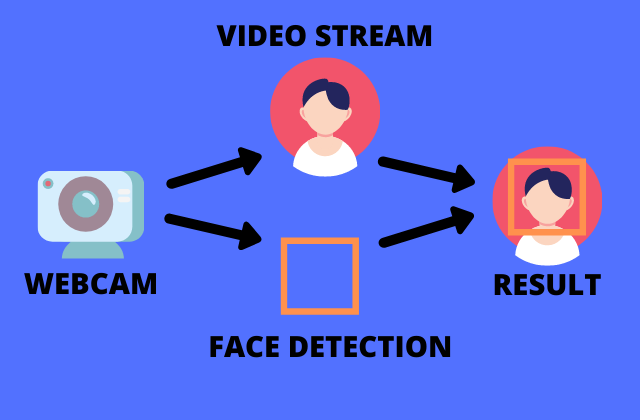</center>

In [ ]:
# start streaming video from webcam
video_stream()
# label for video
label_html = 'Capturing...'
# initialze bounding box to empty
bbox = ''
count = 0 
while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    # convert JS response to OpenCV Image
    img = js_to_image(js_reply["img"])

    # create transparent overlay for bounding box
    bbox_array = np.zeros([480,640,4], dtype=np.uint8)

    # grayscale image for face detection
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # get face region coordinates
    faces = face_cascade.detectMultiScale(gray,1.1, 8)

    # get face bounding box for overlay
    for (x,y,w,h) in faces:
      bbox_array = cv2.rectangle(bbox_array,(x,y),(x+w,y+h),(0,0,255),2)

      center = (x + w//2, y + h//2)
      #bbox_array = cv2.ellipse(bbox_array, center, (w//2, h//2), 0, 0, 360, (255, 0, 255), 4)
      faceROI = gray[y:y+h,x:x+w]
      #-- In each face, detect eyes
      eyes = eyes_cascade.detectMultiScale(faceROI)
      for (x2,y2,w2,h2) in eyes:
          eye_center = (x + x2 + w2//2, y + y2 + h2//2)
          radius = int(round((w2 + h2)*0.25))
          bbox_array = cv2.circle(bbox_array, eye_center, radius, (255, 0, 0 ), 4)

    profiles = profile_cascade.detectMultiScale(gray,1.1, 8)
    for (x,y,w,h) in profiles:
      bbox_array = cv2.rectangle(bbox_array,(x,y),(x+w,y+h),(0,255,0),2)


    bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
    # convert overlay of bbox into bytes
    bbox_bytes = bbox_to_bytes(bbox_array)
    # update bbox so next frame gets new overlay
    bbox = bbox_bytes

## Deep learning Face detection

Face detection with mtcnn on a photograph.

MTCNN or Multi-Task Cascaded Convolutional Neural Networks is a neural network which detects faces and facial landmarks on images. MTCNN is one of the most popular and most accurate face detection tools today

[White Paper] https://ieeexplore.ieee.org/abstract/document/7553523

[More detail] https://towardsdatascience.com/how-does-a-face-detection-program-work-using-neural-networks-17896df8e6ff

In [ ]:
# draw an image with detected objects
def draw_image_with_boxes(filename, result_list):
	# load the image
	data = pyplot.imread(filename)
	# plot the image
	pyplot.imshow(data)
	# get the context for drawing boxes
	ax = pyplot.gca()
	# plot each box
	for result in result_list:
		# get coordinates
		x, y, width, height = result['box']
		# create the shape
		rect = Rectangle((x, y), width, height, fill=False, color='red')
		# draw the box
		ax.add_patch(rect)
		# draw the dots
		for key, value in result['keypoints'].items():
			# create and draw dot
			dot = Circle(value, radius=2, color='red')
			ax.add_patch(dot)
	# show the plot
	pyplot.show()

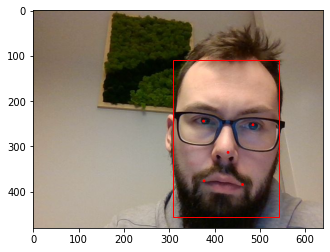

In [ ]:
# create the detector, using default weights
detector = MTCNN()
# detect faces in the image
faces = detector.detect_faces(pyplot.imread(FILE_NAME))
# display faces on the original image
draw_image_with_boxes(FILE_NAME, faces)

### Webcam Live Stream

In [ ]:
# start streaming video from webcam
video_stream()
# label for video
label_html = 'Capturing...'
# initialze bounding box to empty
bbox = ''
count = 0 

detector = MTCNN()

while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    # convert JS response to OpenCV Image
    img = js_to_image(js_reply["img"])

    # create transparent overlay for bounding box
    bbox_array = np.zeros([480,640,4], dtype=np.uint8)

    # grayscale image for face detection
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    #cv2_imshow(gray)
    
    # detect faces in the image
    faces = detector.detect_faces(img)

    #print(faces[0]['box'])

    for face in faces:
      x, y, width, height = face['box']
      # create the shape
      center = (x + width//2, y + height//2)
      #bbox_array = cv2.ellipse(bbox_array, center, (w//2, h//2), 0, 0, 360, (255, 0, 0), 2)
      bbox_array = cv2.rectangle(bbox_array,(x,y),(x+width,y+height),(0,255,0),2)

      for key, value in face['keypoints'].items():
        # create and draw dot
        #dot = Circle(value, radius=2, color='red')
        #radius = int(round((w2 + h2)*0.25))
        bbox_array = cv2.ellipse(bbox_array, value, (3, 3), 0, 0, 360, (0, 0, 255), 4)
        
  
    
    bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
    # convert overlay of bbox into bytes
    bbox_bytes = bbox_to_bytes(bbox_array)
    # update bbox so next frame gets new overlay
    bbox = bbox_bytes

<IPython.core.display.Javascript object>

# Face verification

Face Verification task depicts a 1:1 classification where the image of the subject is compared to a pre-exisiting image of the person. These two images are compared and if the similarity of the encoding of these to images is above the pre-set threshold, the system conveys the message that the 2 pictures are of the same person.

In [ ]:
# get some external photos
!wget 'https://upload.wikimedia.org/wikipedia/commons/6/67/Keanu_Reeves-2019.jpg' -O keanu.jpg
!wget 'https://upload.wikimedia.org/wikipedia/commons/1/19/BettyWhiteJune09.jpg' -O betty.jpg

--2021-12-29 20:45:23--  https://upload.wikimedia.org/wikipedia/commons/6/67/Keanu_Reeves-2019.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 208.80.154.240, 2620:0:861:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|208.80.154.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1505004 (1.4M) [image/jpeg]
Saving to: ‘keanu.jpg’

keanu.jpg           100%[===================>]   1.43M  --.-KB/s    in 0.09s   

2021-12-29 20:45:23 (15.4 MB/s) - ‘keanu.jpg’ saved [1505004/1505004]

--2021-12-29 20:45:23--  https://upload.wikimedia.org/wikipedia/commons/1/19/BettyWhiteJune09.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 208.80.154.240, 2620:0:861:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|208.80.154.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1749123 (1.7M) [image/jpeg]
Saving to: ‘betty.jpg’

betty.jpg           100%[===================>]   1.67M  --.-KB/s 

## VGGFace2

Face verification with the VGGFace2 model

[White Paper] https://ieeexplore.ieee.org/abstract/document/8373813

[GitHub] https://github.com/rcmalli/keras-vggface

In [ ]:
#helper functions

# extract a single face from a given photograph
def extract_face(filename, required_size=(224, 224)):
	# load image from file
	pixels = pyplot.imread(filename)
	# create the detector, using default weights
	detector = MTCNN()
	# detect faces in the image
	results = detector.detect_faces(pixels)
	# extract the bounding box from the first face
	x1, y1, width, height = results[0]['box']
	x2, y2 = x1 + width, y1 + height
	# extract the face
	face = pixels[y1:y2, x1:x2]
	# resize pixels to the model size
	image = Img.fromarray(face)
	image = image.resize(required_size)
	face_array = asarray(image)
	return face_array
 
# extract faces and calculate face embeddings for a list of photo files
def get_embeddings(filenames):
  # extract faces
  faces = [extract_face(f) for f in filenames]
  # convert into an array of samples
  samples = asarray(faces, 'float32')
  # prepare the face for the model, e.g. center pixels
  samples = preprocess_input(samples, version=2)
  # create a vggface model
  model = VGGFace(model='resnet50', include_top=False, input_shape=(224, 224, 3), pooling='avg')
  # perform prediction
  yhat = model.predict(samples)
  return yhat
 
# determine if a candidate face is a match for a known face
def is_match(known_embedding, candidate_embedding, thresh=0.5):
	# calculate distance between embeddings
	score = cosine(known_embedding, candidate_embedding)
	if score <= thresh:
		print('>face is a Match (%.3f <= %.3f)' % (score, thresh))
	else:
		print('>face is NOT a Match (%.3f > %.3f)' % (score, thresh))
 
def compare_twoImages(img1, img2):
  detector = MTCNN()
  model = VGGFace(model='resnet50', include_top=False, input_shape=(224, 224, 3), pooling='avg')

  results1 = detector.detect_faces(cv2.resize(img1,(224,224)))
  x1, y1, width, height = results1[0]['box']
  x2, y2 = x1 + width, y1 + height
  face = img1[y1:y2, x1:x2]
  image1 = Img.fromarray(face)
  image1 = image1.resize((224, 224))
  face_array = asarray(image1)
  face_array = np.expand_dims(face_array, axis=0)
  sample1 = asarray(face_array, 'float32')
  sample1 = preprocess_input(sample1, version=2)
  img1_embedding = model.predict(sample1)

  results2 = detector.detect_faces(cv2.resize(img2,(224,224)))
  x1, y1, width, height = results2[0]['box']
  x2, y2 = x1 + width, y1 + height
  face = img1[y1:y2, x1:x2]
  image2 = Img.fromarray(face)
  image2 = image2.resize((224, 224))
  face_array = asarray(image2)
  face_array = np.expand_dims(face_array, axis=0)
  sample2 = asarray(face_array, 'float32')
  sample2 = preprocess_input(sample2, version=2)
  img2_embedding = model.predict(sample2)

  thresh = 0.5
  score = cosine(img1_embedding, img2_embedding)
  if score <= thresh:
    print('>face is a Match (%.3f <= %.3f)' % (score, thresh))
  else:
    print('>face is NOT a Match (%.3f > %.3f)' % (score, thresh))

(224, 224, 3)
(4, 224, 224, 3)
(4, 224, 224, 3)
Negative Tests
>face is NOT a Match (0.622 > 0.500)


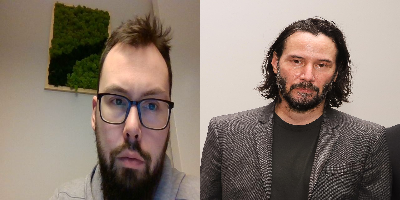

>face is NOT a Match (0.769 > 0.500)


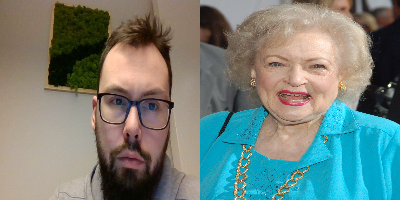

>face is a Match (0.221 <= 0.500)


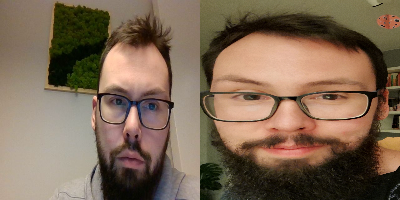

In [ ]:
# define filenames
filenames = [FILE_NAME,'keanu.jpg','betty.jpg','LR.jpg']
# get embeddings file filenames
embeddings = get_embeddings(filenames)
# define your embedding
your_id = embeddings[0] # vector of 2048 features

# verify with known photos of other
print('Negative Tests')
is_match(embeddings[0], embeddings[1])
cv2_imshow(cv2.hconcat((cv2.resize(cv2.imread(filenames[0]),(200,200)), cv2.resize(cv2.imread(filenames[1]),(200,200)) )))
is_match(embeddings[0], embeddings[2])
cv2_imshow(cv2.hconcat((cv2.resize(cv2.imread(filenames[0]),(200,200)), cv2.resize(cv2.imread(filenames[2]),(200,200)) )))
is_match(embeddings[0], embeddings[3])
cv2_imshow(cv2.hconcat((cv2.resize(cv2.imread(filenames[0]),(200,200)), cv2.resize(cv2.imread(filenames[3]),(200,200)) )))

In [ ]:
btn_run = widgets.Button(description='Verify')
lbl_pred = widgets.Label()
out_pl = widgets.Output()

def on_click_classify(change):
    img1 = pyplot.imread(FILE_NAME)
    img2 = cv2.imdecode(np.frombuffer(btn_upload.data[-1], np.uint8), -1)
    compare_twoImages(img1, img2)
    cv2_imshow(cv2.hconcat((cv2.resize(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB),(200,200)), cv2.resize(img2,(200,200)) )))

btn_run.on_click(on_click_classify)

>face is a Match (0.255 <= 0.500)


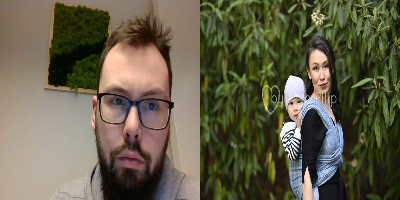

>face is a Match (0.255 <= 0.500)


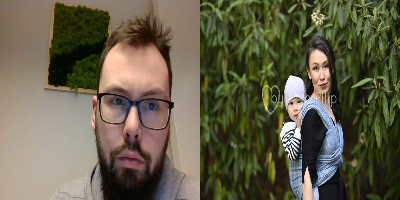

In [ ]:
btn_upload = widgets.FileUpload(multiple=False)
widgets.VBox([btn_upload, btn_run, out_pl, lbl_pred])

## Deep Face

Deepface is a lightweight face recognition and facial attribute analysis (age, gender, emotion and race) framework for python.

[White Paper] https://ieeexplore.ieee.org/document/9259802

[GitHub] https://github.com/serengil/deepface

In [ ]:
from deepface import DeepFace
obj = DeepFace.verify([
      [FILE_NAME, "keanu.jpg"],
      [FILE_NAME, "betty.jpg"],
      #[FILE_NAME, "LR.jpg"],
      [FILE_NAME, "lena.png"],
   ]
   , model_name = "VGG-Face")
#print(obj)

Verification: 100%|██████████| 3/3 [00:07<00:00,  2.60s/it]


{'verified': False, 'distance': 0.42554550567449445, 'max_threshold_to_verify': 0.4, 'model': 'VGG-Face', 'similarity_metric': 'cosine'}


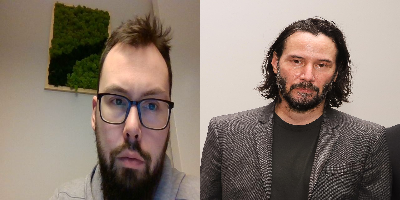

{'verified': False, 'distance': 0.7241252152576516, 'max_threshold_to_verify': 0.4, 'model': 'VGG-Face', 'similarity_metric': 'cosine'}


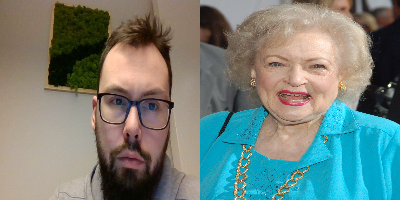

{'verified': False, 'distance': 0.664123680697456, 'max_threshold_to_verify': 0.4, 'model': 'VGG-Face', 'similarity_metric': 'cosine'}


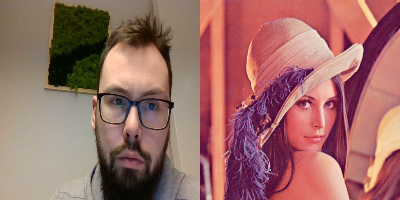

In [ ]:
print(obj['pair_1'])
cv2_imshow(cv2.hconcat((cv2.resize(cv2.imread(FILE_NAME),(200,200)), cv2.resize(cv2.imread('keanu.jpg'),(200,200)) )))
print(obj['pair_2'])
cv2_imshow(cv2.hconcat((cv2.resize(cv2.imread(FILE_NAME),(200,200)), cv2.resize(cv2.imread('betty.jpg'),(200,200)) )))
print(obj['pair_3'])
cv2_imshow(cv2.hconcat((cv2.resize(cv2.imread(FILE_NAME),(200,200)), cv2.resize(cv2.imread('lena.png'),(200,200)) )))

In [ ]:
obj2 = DeepFace.analyze(img_path = FILE_NAME, actions = ['age', 'gender', 'race', 'emotion'])

Action: emotion: 100%|██████████| 4/4 [00:02<00:00,  1.58it/s]


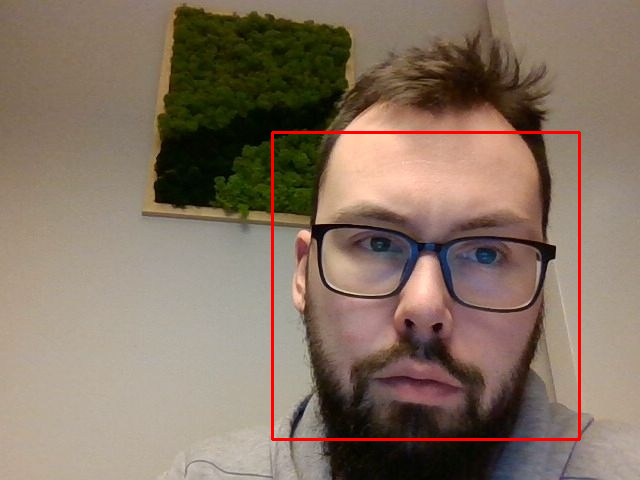

{'age': 30,
 'dominant_emotion': 'neutral',
 'dominant_race': 'white',
 'emotion': {'angry': 4.86498454332536,
  'disgust': 3.547284993647064e-05,
  'fear': 0.7625367980406526,
  'happy': 1.4140084394176355e-05,
  'neutral': 79.23731455358093,
  'sad': 15.134858770983366,
  'surprise': 0.00025237122092330476},
 'gender': 'Man',
 'race': {'asian': 2.4188751354813576,
  'black': 0.6258243694901466,
  'indian': 4.932671412825584,
  'latino hispanic': 20.903465151786804,
  'middle eastern': 29.916703701019287,
  'white': 41.2024587392807},
 'region': {'h': 307, 'w': 307, 'x': 272, 'y': 132}}

In [ ]:
temp_img = cv2.imread(FILE_NAME)
temp_img = cv2.rectangle(temp_img,(obj2['region']['x'],obj2['region']['y']),(obj2['region']['x']+obj2['region']['w'],obj2['region']['y']+obj2['region']['h']),(0,0,255),2)
cv2_imshow(temp_img)
obj2

# Credits

1. https://docs.opencv.org/3.4/db/d28/tutorial_cascade_classifier.html
2.  https://github.com/theAIGuysCode/colab-webcam
3.  https://machinelearningmastery.com/how-to-perform-face-detection-with-classical-and-deep-learning-methods-in-python-with-keras/
4.  https://machinelearningmastery.com/how-to-perform-face-recognition-with-vggface2-convolutional-neural-network-in-keras/

# Other

In [ ]:
from ipywebrtc import CameraStream, ImageRecorder

In [ ]:
front_camera = CameraStream.facing_user(audio=False)
image_recorder = ImageRecorder(stream=front_camera)
image_recorder

In [ ]:
#out = Image()
stop_process = False

def process_image(_):
  if stop_process:
    return
    im_in = PIL.Image.open(io.BytesIO(image_recorder.image.value))
    im_array = np.array(im_in)[...,:3]
    img_gray = cv2.cvtColor(im_array, cv2.COLOR_BGR2GRAY)
    im_array_edges = cv2.Canny(image=img_gray, threshold1=100, threshold2=200)
    im_out = PIL.Image.fromarray(im_array_edges)

    image_recorder.recording = True

image_recorder.image.observe(process_image, names=['value'])


In [ ]:
stop_process = True

In [ ]:

im = PIL.Image.open(io.BytesIO(image_recorder.image.value))
im_array = np.array(im)

In [ ]:
from skimage.filters import roberts, sobel, scharr, prewitt
from skimage.color import rgb2gray
from skimage.color.adapt_rgb import adapt_rgb, each_channel, hsv_value
from skimage import filters
import numpy as np

from ipywebrtc import CameraStream, ImageRecorder
front_camera = CameraStream.facing_user(audio=False)
image_recorder = ImageRecorder(stream=front_camera)

image = widgets.Image()
output = widgets.Output()
filter_options = [('roberts', roberts), ('sobel', sobel), ('scharr', scharr), ('prewitt', prewitt)]
filter_widget = widgets.ToggleButtons(options=filter_options)

@output.capture()
def update_image(change):
    # turn into nparray
    im_in = PIL.Image.open(io.BytesIO(image_recorder.image.value))
    im_array = np.array(im_in)[...,:3] # no alpha
    
    # filter
    filter_function = filter_widget.value
    im_array_edges = adapt_rgb(each_channel)(filter_function)(im_array)
    im_array_edges = ((1-im_array_edges) * 255).astype(np.uint8)
    im_out = PIL.Image.fromarray(im_array_edges)
    
    # store in image widget
    f = io.BytesIO()
    im_out.save(f, format='png')
    image.value = f.getvalue()

image_recorder.image.observe(update_image, 'value')
filter_widget.observe(update_image, 'value')
widgets.VBox([filter_widget, front_camera, widgets.HBox([image_recorder, image]), output])

In [ ]:
from skimage.filters import roberts, sobel, scharr, prewitt
from skimage.color import rgb2gray
from skimage.color.adapt_rgb import adapt_rgb, each_channel, hsv_value
from skimage import filters
import numpy as np

from ipywebrtc import CameraStream, ImageRecorder
front_camera = CameraStream.facing_user(audio=False)
image_recorder = ImageRecorder(stream=front_camera)

image = widgets.Image()
output = widgets.Output()
filter_options = [('roberts', roberts), ('sobel', sobel), ('scharr', scharr), ('prewitt', prewitt)]
filter_widget = widgets.ToggleButtons(options=filter_options)

face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
eyes_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye_tree_eyeglasses.xml') # haarcascade_eye_tree_eyeglasses  haarcascade_eye


@output.capture()
def update_image(change):
    # turn into nparray
    im_in = PIL.Image.open(io.BytesIO(image_recorder.image.value))
    im_array = np.array(im_in)[...,:3] # no alpha
    
    # filter
    filter_function = filter_widget.value
    im_array_edges = adapt_rgb(each_channel)(filter_function)(im_array)
    im_array_edges = ((1-im_array_edges) * 255).astype(np.uint8)
    #im_out = PIL.Image.fromarray(im_array_edges)
    
    
    # create transparent overlay for bounding box
    bbox_array = np.zeros([480,640,4], dtype=np.uint8)

    # grayscale image for face detection
    gray = cv2.cvtColor(im_array, cv2.COLOR_RGB2GRAY)

    img = np.array(im_in) 
    # Convert RGB to BGR 
    #img = img[:, :, ::-1].copy() 
    
    # get face region coordinates
    faces = face_cascade.detectMultiScale(gray,1.1, 8)
    
    # draw face bounding box on image
    for (x,y,w,h) in faces:
        img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)

        center = (x + w//2, y + h//2)
        img = cv2.ellipse(img, center, (w//2, h//2), 0, 0, 360, (255, 0, 255), 4)
        faceROI = gray[y:y+h,x:x+w]
        #-- In each face, detect eyes
        eyes = eyes_cascade.detectMultiScale(faceROI)
        for (x2,y2,w2,h2) in eyes:
            eye_center = (x + x2 + w2//2, y + y2 + h2//2)
            radius = int(round((w2 + h2)*0.25))
            img = cv2.circle(img, eye_center, radius, (255, 0, 0 ), 4)

  
    
    bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
    # convert overlay of bbox into bytes
    bbox_bytes = bbox_to_bytes(bbox_array)
    
    
    im_out = PIL.Image.fromarray(img)
    
    
    # store in image widget
    f = io.BytesIO()
    im_out.save(f, format='png')
    image.value = f.getvalue()
    image_recorder.recording = True

image_recorder.image.observe(update_image, 'value')
filter_widget.observe(update_image, 'value')
widgets.VBox([filter_widget, front_camera, widgets.HBox([image_recorder, image]), output])

In [ ]:

out = widgets.Image()
stop_process = False

def process_image(_):
    if stop_process:
        return
    
    im_in = PIL.Image.open(io.BytesIO(image_recorder.image.value))
    im_array = np.array(im_in)[...,:3] # no alpha
    
    # filter
    filter_function = filter_widget.value
    im_array_edges = adapt_rgb(each_channel)(filter_function)(im_array)
    im_array_edges = ((1-im_array_edges) * 255).astype(np.uint8)
    im_out = PIL.Image.fromarray(im_array_edges)
    
    # store in image widget
    f = io.BytesIO()
    im_out.save(f, format='png')
    out.value = f.getvalue()
    image_recorder.recording = True
    
image_recorder.image.observe(process_image, names=['value'])
widgets.HBox([out, image_recorder])
